In [1]:
import io
import pynlo
import pstats
import cProfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit
from scipy import constants
from scipy.fft import fft, ifft
from dataclasses import dataclass

In [2]:
@dataclass
class GasPropertyData:
    name: str
    beta2: float          # [fs^2/(cm bar)]
    beta3: float          # [fs^3/(cm bar)]
    beta4: float          # [fs^4/(cm bar)]
    n2_at_one_bar: float  # [m^2/(W bar)]
    
    def __repr__(self):
        return (f"{self.name}: beta2={self.beta2} fs^2/(cm bar), "
                f"beta3={self.beta3} fs^3/(cm bar), "
                f"beta4={self.beta4} fs^4/(cm bar), "
                f"n2_at_one_bar={self.n2_at_one_bar} m^2/(W bar)")

noble_gases = [
    GasPropertyData(name="Neon", beta2=0.0202, beta3=0.0158, beta4=0, n2_at_one_bar=0.14e-23),
    GasPropertyData(name="Argon", beta2=0.1980, beta3=0.1586, beta4=0, n2_at_one_bar=1.74e-23),
    GasPropertyData(name="Krypton", beta2=0.3996, beta3=0.3298, beta4=0, n2_at_one_bar=4.03e-23),
    GasPropertyData(name="Xenon", beta2=0.9113, beta3=0.7836, beta4=0, n2_at_one_bar=11.15e-23),
]

In [3]:
def loadGasParameters(gas_name, gases):
    
    gas_dict = {gas.name.lower(): gas for gas in gases}
    gas = gas_dict.get(gas_name.lower(), "Gas property not found.")

    n2_at_one_bar = gas.n2_at_one_bar
    beta2 = gas.beta2 * (1e-3)**2 / 1e-5    # [ps^2/(km bar)]
    beta3 = gas.beta3 * (1e-3)**3 / 1e-5    # [ps^3/(km bar)]
    beta4 = gas.beta4 * (1e-3)**4 / 1e-5    # [ps^4/(km bar)]
    betas_at_one_bar = [beta2, beta3, beta4]
    
    return n2_at_one_bar, betas_at_one_bar

In [4]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False, pressure_in_Torr=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
        self.pressure_in_Torr = pressure_in_Torr

    
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar
    
    def pressureDistribution(self, z=None):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        if self.differential_pumping:
            if self.pressure_in_Torr:
                pressure_entr = self.torrToBar(self.pressure_entr)
                pressure_exit = self.torrToBar(self.pressure_exit)
            else:
                pressure_entr = self.pressure_entr
                pressure_exit = self.pressure_exit
            
            pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        else:
            if self.pressure_in_Torr:
                pressure_dist = self.torrToBar(self.const_pressure)
            else:
                pressure_dist = self.const_pressure

        return pressure_dist
    
    def dispersionFunction(self, z=None):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """

        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
            
        betas = [beta * (1/1e3) * pressure_dist for beta in self.betas_at_one_bar]
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
        else:
            pressure_dist = self.pressureDistribution()
        
        n2 = pressure_dist * self.n2_at_one_bar
        
        return n2
    
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        
        if self.differential_pumping:
            n2 = self.nonlinearIndexN2(z)
        else:
            n2 = self.nonlinearIndexN2()
            
        Gamma = (n2*w0) / (constants.c*A_eff)
        
        return Gamma


In [5]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar * w = h * v
    E[eV] = E[J] / e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * pulse.F_mks / constants.e
    
    return W_eV

In [6]:
def dB(num):
    return 10 * np.log10(np.abs(num)**2)

In [7]:
def calc_FWHM(pulse):
    
    t = pulse.T_mks
    temporal_intensity = np.abs(pulse.AT)**2
    normalized_temporal_intensity = temporal_intensity / np.max(temporal_intensity)
    
    FWHM_filter = np.where(normalized_temporal_intensity >= 0.5)[0]
    
    if len(FWHM_filter) >= 2:
        FWHM_mks = t[FWHM_filter[-1]] - t[FWHM_filter[0]]
        return FWHM_mks
    else:
        print("Pulse does not have a well-defined FWHM.")
        return None

In [8]:
def super_gaussian(x, x0, w, n):
    """
    Generates a super-Gaussian distribution.

    Input(s):
    x: the input array over which the super-Gaussian function is evaluated
    x0: the center of the super-Gaussian peak
    w: the width of the super-Gaussian, controlling the spread of the function
    n: the order of the super-Gaussian (2 is a Gaussian, higher values create a flatter top and sharper edges)
    Output(s):
    super_gaussian: a super-Gaussian distribution
    """
    
    super_gaussian = np.exp(- ((x-x0)/w) ** n)
    return super_gaussian

In [9]:
class PeakIntensityBuilder:
    
    def __init__(self, SHG_efficiency, pulse_duration, pulse_shape='sech', peak_intensity_CGS=None):
        
        self.eta = SHG_efficiency
        self.FWHM = pulse_duration                                # [s]
        self.peak_intensity_CGS = peak_intensity_CGS              # [W/cm^2]
        self.peak_intensity_MKS = self.toMKS(peak_intensity_CGS)  # [W/m^2]

        if pulse_shape == "sech":
            self.power_scaling_factor = np.arccosh(np.sqrt(2))
        elif pulse_shape == "gaussian":
            self.power_scaling_factor = 2 * np.sqrt(np.log(2)/np.pi)
            
    def toMKS(self, intensity_CGS):
        """
        Unit conversion for optical intensity from W/cm^2 to W/m^2.
        
        Input(s):
        intensity_CGS: intensity [W/cm^2]
        Output(s):
        intensity_MKS: intensity [W/m^2]
        """
        intensity_MKS = intensity_CGS / (1e-2)**2
        return intensity_MKS
    
    def toCGS(self, intensity_MKS):
        """
        Unit conversion for optical intensity from W/m^2 to W/cm^2.
        
        Input(s):
        intensity_MKS: intensity [W/m^2]
        Output(s):
        intensity_CGS: intensity [W/cm^2]
        """
        intensity_CGS = intensity_MKS / (1e2)**2
        return intensity_CGS
    
    def divideEPP(self, input_EPP):
        
        EPP_FD = (1 - self.eta) * input_EPP
        EPP_SH = self.eta * input_EPP
        return EPP_FD, EPP_SH
    
    def calcFiberRadius(self, input_EPP):
        """
        Calculate the maximum fiber radius in [m] that maintains the required peak intensity
        for a given pulse energy and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        
        EPP_FD, EPP_SH = self.divideEPP(input_EPP)
        fiber_rad = np.sqrt((self.power_scaling_factor * EPP_SH) / (self.peak_intensity_MKS * self.FWHM * np.pi))
        return fiber_rad
    
    def calcPeakIntensity(self, reference_EPP, fiber_radius):
        """
        Calculate the resulting peak intensity in [W/cm^2] from the given pulse energy,
        pulse duration and fiber radius.
        """
        peak_intensity_MKS = (self.power_scaling_factor * reference_EPP) / (self.FWHM * np.pi * fiber_radius**2)
        peak_intensity_CGS = self.toCGS(peak_intensity_MKS)
        return peak_intensity_CGS
    
    def calcEPP(self, fiber_radius):
        """
        Calculate the pulse energies in [J] that maintain the required peak intensity
        for a given fiber radius and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        
        EPP_SH = self.peak_intensity_MKS * self.FWHM * np.pi * fiber_radius**2 / self.power_scaling_factor
        input_EPP = EPP_SH / self.eta
        EPP_FD = (1 - self.eta) * input_EPP
        return input_EPP, EPP_FD, EPP_SH
        

In [10]:
class PulsePropertyAccessor:
    
    def __init__(self, pulse, pulse_shape="sech"):
        
        self.pulse = pulse
        
        if pulse_shape == "sech":
            self.autocorrelation_scaling_factor = 0.6482
            self.power_scaling_factor = np.arccosh(np.sqrt(2))
        elif pulse_shape == "gaussian":
            self.autocorrelation_scaling_factor = 0.7071
            self.power_scaling_factor = 2 * np.sqrt(np.log(2)/np.pi)
    
    def calc_epp(self):
        
        pulse_energy = self.pulse.calc_epp()
        return pulse_energy
        
    def calc_pulse_length(self):
        
        intensity_autocorrelation = fft_autocorrelation(np.abs(self.pulse.AT)**2)
        pulse_FWHM = calc_pulse_length_numba(self.pulse.T_mks, intensity_autocorrelation, self.autocorrelation_scaling_factor)
        return pulse_FWHM
        
    def calc_peak_power(self):
        
        pulse_energy = self.calc_epp()
        pulse_FWHM = self.calc_pulse_length()
        peak_power = calc_peak_power_numba(pulse_energy, pulse_FWHM, self.power_scaling_factor)
        return peak_power

def fft_autocorrelation(signal):
    
    n = len(signal)
    f_signal = fft(signal)
    f_signal_conj = np.conj(f_signal)
    result = ifft(f_signal * f_signal_conj).real
    return np.fft.fftshift(result) / n

@njit
def calc_pulse_length_numba(T_mks, intensity_autocorrelation, autocorrelation_scaling_factor):
    
    half_maximum = np.max(intensity_autocorrelation) / 2
    indices_above_half_maximum = np.where(intensity_autocorrelation >= half_maximum)[0]
    FWHM_autocorrelation = T_mks[indices_above_half_maximum[-1]] - T_mks[indices_above_half_maximum[0]]
    FWHM_pulse = FWHM_autocorrelation * autocorrelation_scaling_factor
    return FWHM_pulse

@njit
def calc_peak_power_numba(pulse_energy, pulse_FWHM, power_scaling_factor):
    
    peak_power = pulse_energy * power_scaling_factor / pulse_FWHM
    return peak_power

In [11]:
class PlotConstructor:
    
    def __init__(self, AW, AT, pulse_FD, pulse_SH, pulse, pulse_out, fiber_len):
        self.AW = AW
        self.AT = AT
        self.pulse_FD = pulse_FD
        self.pulse_SH = pulse_SH
        self.pulse = pulse
        self.pulse_out = pulse_out
        self.fiber_len = fiber_len
        self.W_eV = photonEnergyGrid(pulse_SH)
        self.zW = dB(np.transpose(AW)[:, (self.W_eV > 0)])
        self.zT = dB(np.transpose(AT))
        self.saved_plots = {}

    def spectral_power_density(self, save=True):
        plt.figure()
        plt.plot(self.W_eV[self.W_eV > 0], np.abs(self.pulse_out.AW[self.W_eV > 0])**2, color='r', label='output pulse')
        plt.xlabel('Photon energy [eV]')
        plt.ylabel('Spectral power density [W/eV]')
        plt.yscale('log')
        plt.xlim(0, 20)
        plt.ylim(bottom=1e-15)
        
        if save:
            plt.savefig('plot1.png')
        self.saved_plots['spectral_power_density'] = plt.gcf()
        plt.show()
        plt.close()

    def temporal_power_density(self, save=True):
        plt.figure()
        plt.plot(self.pulse_SH.T_ps, np.abs(self.pulse_out.AT)**2, color='r', label='output pulse')
        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        plt.xticks(x_ticks)
        plt.xlim(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps))
        plt.xlabel('Time [ps]')
        plt.ylabel('Temporal power density [W/eV]')
        plt.yscale('log')
        
        if save:
            plt.savefig('plot2.png')
        self.saved_plots['temporal_power_density'] = plt.gcf()
        plt.show()
        plt.close()

    def spectral_broadening_along_fiber(self, save=True):
        plt.figure()
        extent = (np.min(self.W_eV[self.W_eV > 0]), np.max(self.W_eV[self.W_eV > 0]), 0, self.fiber_len)
        plt.imshow(self.zW, extent=extent, vmin=np.max(self.zW) - 250.0, vmax=np.max(self.zW), aspect='auto', origin='lower', cmap='jet')
        plt.xlim(0, 20)
        plt.xlabel('Photon energy [eV]')
        plt.ylabel('Propagation distance [mm]')
        
        if save:
            plt.savefig('plot3.png')
        self.saved_plots['spectral_broadening_along_fiber'] = plt.gcf()
        plt.show()
        plt.close()

    def temporal_broadening_along_fiber(self, save=True):
        plt.figure()
        extent = (np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps), 0, self.fiber_len)
        plt.imshow(self.zT, extent=extent, vmin=np.max(self.zT) - 60.0, vmax=np.max(self.zT), aspect='auto', origin='lower', cmap='jet')
        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        plt.xticks(x_ticks)
        plt.xlabel('Time [ps]')
        plt.ylabel('Propagation distance [mm]')
        
        if save:
            plt.savefig('plot4.png')
        self.saved_plots['temporal_broadening_along_fiber'] = plt.gcf()
        plt.show()
        plt.close()

    def combined_plot(self, save=True):
        fig = plt.figure(figsize=(15, 10))
        ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
        ax1 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
        ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, sharex=ax0)
        ax3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, sharex=ax1)

        ax0.plot(self.W_eV[self.W_eV > 0], np.abs(self.pulse_out.AW[self.W_eV > 0])**2, color='r', label='output pulse')
        ax1.plot(self.pulse_SH.T_ps, np.abs(self.pulse_out.AT)**2, color='r', label='output pulse')

        extent_W = (np.min(self.W_eV[self.W_eV > 0]), np.max(self.W_eV[self.W_eV > 0]), 0, self.fiber_len)
        ax2.imshow(self.zW, extent=extent_W, vmin=np.max(self.zW) - 250.0, vmax=np.max(self.zW), aspect='auto', origin='lower', cmap='jet')

        extent_T = (np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps), 0, self.fiber_len)
        ax3.imshow(self.zT, extent=extent_T, vmin=np.max(self.zT) - 60.0, vmax=np.max(self.zT), aspect='auto', origin='lower', cmap='jet')

        ax0.set_xlim(0, 20)
        ax0.set_ylim(bottom=1e-15)

        x_ticks = np.arange(np.min(self.pulse_SH.T_ps), np.max(self.pulse_SH.T_ps) + 1, 1)
        ax1.set_xticks(x_ticks)

        ax0.set_yscale('log')
        ax1.set_yscale('log')

        ax0.set_ylabel('Spectral power density [W/eV]')
        ax1.set_ylabel('Temporal power density [W/eV]')
        ax2.set_ylabel('Propagation distance [mm]')
        ax3.set_ylabel('Propagation distance [mm]')

        ax2.set_xlabel('Photon energy [eV]')
        ax3.set_xlabel('Time [ps]')

        plt.tight_layout()
        
        if save:
            plt.savefig('combined_plot.png')
        self.saved_plots['combined_plot'] = plt.gcf()
        plt.show()
        plt.close()

    def display_saved_plots(self):
        for plot_name, fig in self.saved_plots.items():
            print(f"Displaying {plot_name}")
            plt.show()


In [12]:
# pulse parameters
FWHM = 0.16                # pulse duration [ps]
pulseWL = 1035             # pulse central wavelength [nm]
GDD = 0.0                  # group delay dispersion [ps^2]
TOD = 0.0                  # third order dispersion [ps^3]

# fiber parameters
Length = 200                               # fiber length [mm]
fiber_rad = 15e-6                          # fiber radius [m]
fibWL = pulseWL                            # center wavelength of fiber [nm]
Alpha = 0.0                                # attentuation coefficient [dB/cm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

# simulation parameters
Window = 3        # simulation window [ps]
Steps = 200       # simulation steps
Points = 2**15    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?


In [13]:
# load gas parameters
n2_at_one_bar, betas_at_one_bar = loadGasParameters('Xenon', noble_gases)

# use differential pumping
gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, fiber_radius=fiber_rad, pulse_wavelength=pulseWL, 
                                betas_at_one_bar=betas_at_one_bar, constant_pressure=None, pressure_boundary=[1000,0], 
                                n2_at_one_bar=n2_at_one_bar, differential_pumping=True, pressure_in_Torr=True)

# create the fiber
fiber = pynlo.media.fibers.fiber.FiberInstance()
fiber.generate_fiber(Length*1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(z=0), 
                     gamma_W_m=gasbuilder.gammaDistribution(z=0), gvd_units='ps^n/m', gain=-alpha)

fiber.set_gamma_function(gasbuilder.gammaDistribution)
fiber.set_dispersion_function(gasbuilder.dispersionFunction, dispersion_format='GVD')

# create the fundamental pulse
pulse_FD = pynlo.light.DerivedPulses.SechPulse(
    1, FWHM/1.76, pulseWL, time_window_ps=Window,
    GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1, power_is_avg=True
)
pulse_FD.set_epp(2e-6)

# create the second harmonic pulse
pulse_SH = pulse_FD.interpolate_to_new_center_wl(pulseWL/2)
pulse_SH.set_epp(2e-6)

# create the combined pulse
pulse = pynlo.light.PulseBase.Pulse()
pulse.set_NPTS(Points)
pulse.set_time_window_ps(Window)
pulse.set_frep_MHz(1)
pulse.set_center_wavelength_nm(fibWL)
pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

# propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True, 
                                                   disable_Raman=np.logical_not(Raman), 
                                                   disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=Steps, reload_fiber_each_step=True)


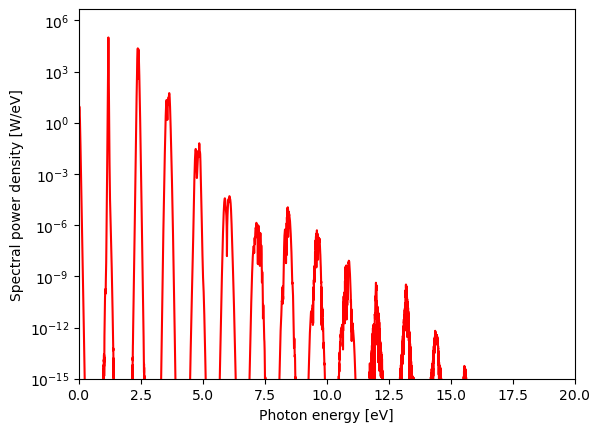

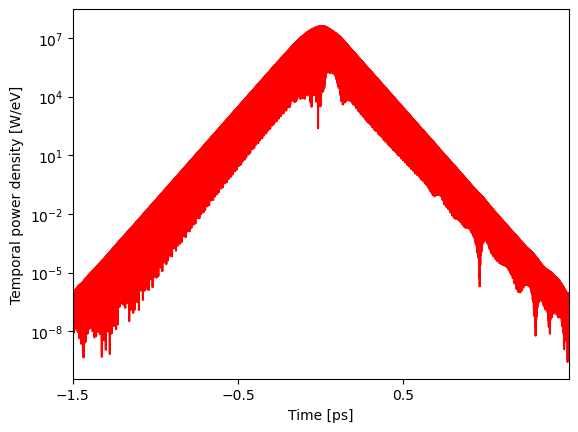

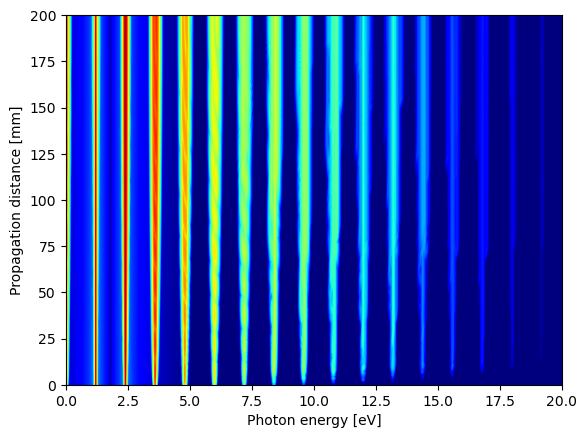

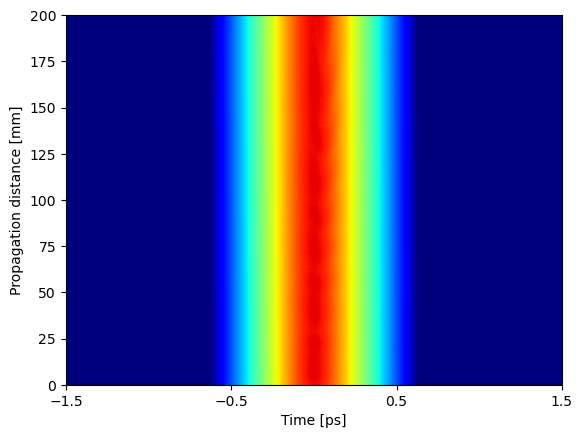

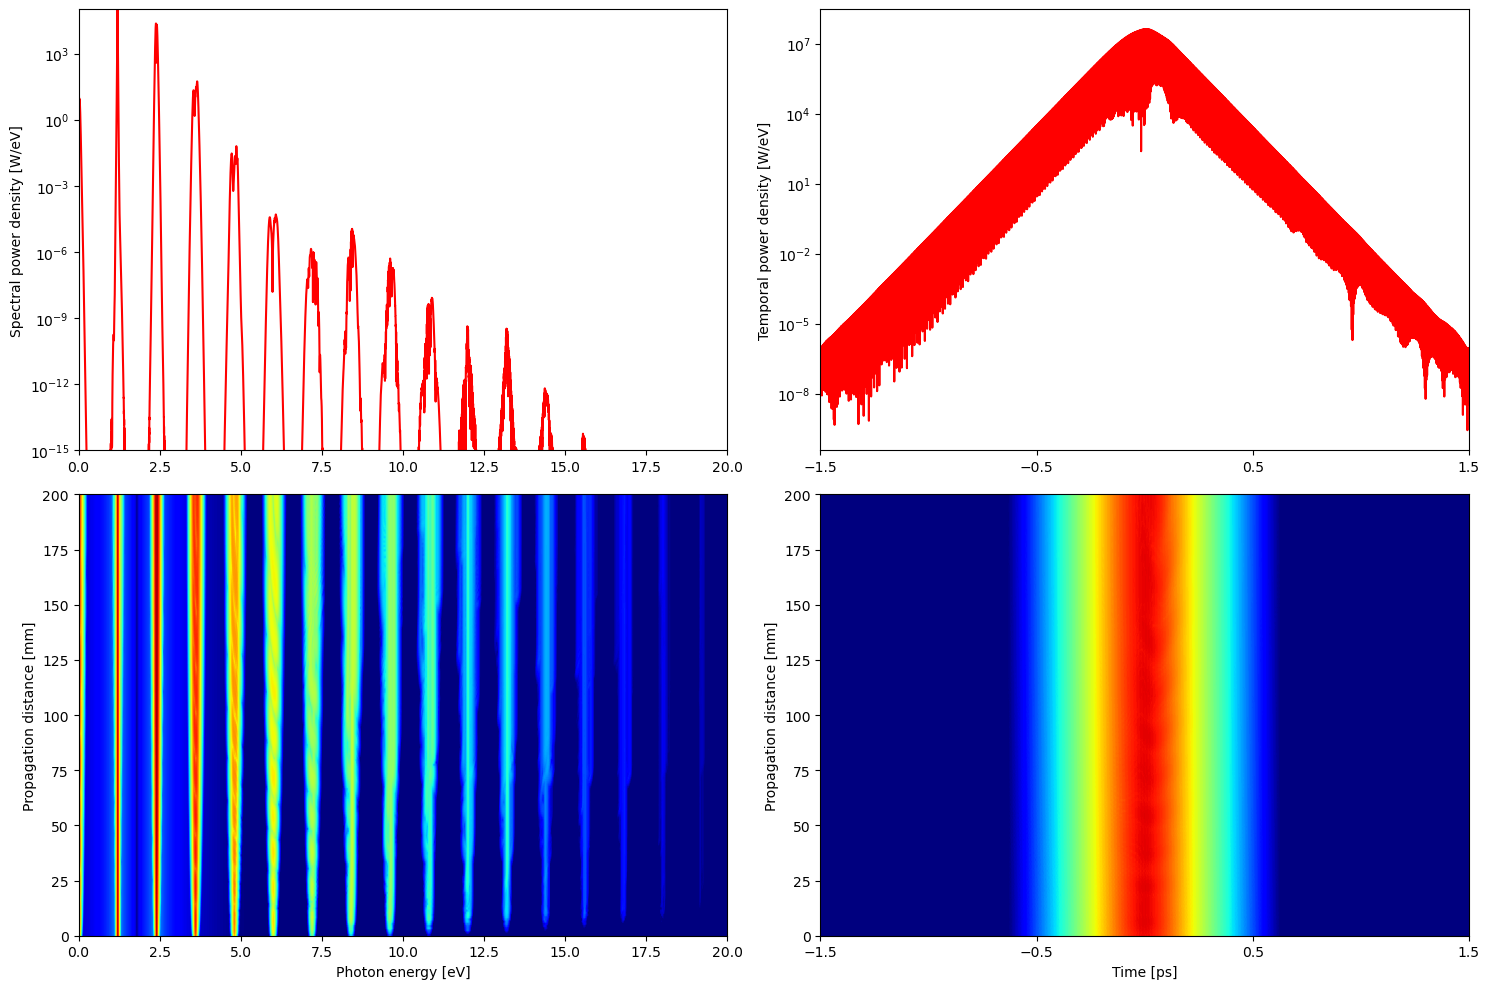

Displaying spectral_power_density
Displaying temporal_power_density
Displaying spectral_broadening_along_fiber
Displaying temporal_broadening_along_fiber
Displaying combined_plot


In [14]:
plotter = PlotConstructor(AW, AT, pulse_FD, pulse_SH, pulse, pulse_out, fiber_len=Length)
plotter.spectral_power_density(save=False)
plotter.temporal_power_density(save=False)
plotter.spectral_broadening_along_fiber(save=False)
plotter.temporal_broadening_along_fiber(save=False)
plotter.combined_plot(save=False)
plotter.display_saved_plots()